# Alamouti Space-time block code

This notebook illustrates the simulation of an Alamouti MIMO scheme transmission through a flat fading Rayleight channel.

It also illustrates how to read configuration from a config file.

## Initializations

In [1]:
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

## The simulator class

Because there is already an Alamouti simulator implemented in the "apps" folder of pyphysim, we simple import it here and set the desired simulation parameters. Basically the `AlamoutiSimulationRunner` class inherts from a `MIMOSimulationRunner` class and sets a "parameter specification".

This specification indicates which parameters should be read from the configuration file, what its default value and some data validation.

A summary of the code of the `MIMOSimulationRunner` class is shown below.

```python
class MIMOSimulationRunner(SimulationRunner):
    def __init__(self,
                 MimoSchemeClass, 
                 config_filename,
                 spec,
                 read_command_line_args=True):
        super().__init__(default_config_file=config_filename,
                         config_spec=spec,
                         read_command_line_args=read_command_line_args,
                         save_parsed_file=True)

        # Set the max_bit_errors and rep_max attributes
        self.max_bit_errors = self.params['max_bit_errors']
        self.rep_max = self.params['rep_max']

        # Create the modulator object
        M = self.params['M']
        modulator_options = {
            'PSK': fundamental.PSK,
            'QPSK': fundamental.QPSK,
            'QAM': fundamental.QAM,
            'BPSK': fundamental.BPSK
        }

        modulator_string = self.params['modulator']
        if modulator_string == 'BPSK' or modulator_string == 'QPSK':
            self.modulator = modulator_options[modulator_string]()
        else:
            self.modulator = modulator_options[modulator_string](M)

        # Create the MIMO object
        self.mimo_object = MimoSchemeClass()

    def _run_simulation(self, current_parameters):
        # xxxxx Input parameters (set in the constructor) xxxxxxxxxxxxxxxxx
        NSymbs = current_parameters["NSymbs"]
        M = self.modulator.M
        Nr = current_parameters["Nr"]
        Nt = current_parameters["Nt"]
        SNR = current_parameters["SNR"]
        # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

        # Code for simulating one iteration
        # ...
        # ...
        
        # Create the `simResults` object and add the results of this iteration to it
        # ...
        
        return simResults

    def _keep_going(self, current_params, simulation_results, current_rep):
        # ... Similar to what we implemented in other notebook examples
```

Notice in the `__init__` method that we are actually using parameters in `self.params` instead of setting them. This is because the values were set by the specification (that will be shown later) and we only use them in the `__init__` method to set some dependent parameters.

The code of the `AlamoutiSimulationRunner` is shown below. Pay attention to the value passed to te `spec` argument.

```python
class AlamoutiSimulationRunner(MIMOSimulationRunner):
    def __init__(self, config_filename, read_command_line_args=True):
        spec = """[Scenario]
        SNR=real_numpy_array(min=0, max=100, default=0:5:21)
        M=integer(min=4, max=512, default=16)
        modulator=option('QPSK', 'PSK', 'QAM', 'BPSK', default="QAM")
        NSymbs=integer(min=10, max=1000000, default=200)
        Nr=integer(min=1,default=1)
        Nt=integer(min=2,max=2,default=2)
        [General]
        rep_max=integer(min=1, default=5000)
        max_bit_errors=integer(min=1, default=5000)
        unpacked_parameters=string_list(default=list('SNR'))
        """.split("\n")

        MIMOSimulationRunner.__init__(
            self,
            mimo.Alamouti,
            config_filename,
            spec,
            read_command_line_args=read_command_line_args)

```

The `spec` argument indicates all parameters that will be added to `self.params`. Below you can see the configuration file that was generated. It is in the "ini" format (saved by the configobj library), which is very easy to change by hand.

```
[Scenario]
        SNR = 0.0, 5.0, 10.0, 15.0, 20.0
        M = 16
        modulator = QAM
        NSymbs = 200
        Nr = 1
        Nt = 2
[General]
        rep_max = 5000
        max_bit_errors = 5000
        unpacked_parameters = SNR,
```

## Simulation of Alamouti with 16-QAM

In [2]:
from pyphysim.modulators.fundamental import BPSK, QAM
from apps.mimo.simulate_mimo import AlamoutiSimulationRunner, plot_ber, plot_ser, plot_ber_and_ser

First we create the SimulationRunner objects. Note that the actual simulator is already implemented as an application in PyPhysim and we are only setting the parameters here.

In [3]:
sim = AlamoutiSimulationRunner('mimo_alamouti_config_file.txt', read_command_line_args=False)
# For the sake of this notebook we are chaning the value here, but you would usually change in the configuration file
sim.params["Nr"] = 1
sim.update_progress_function_style = 'ipython'
sim.progressbar_message = 'Simulating for SNR {SNR}'
# max_bit_errors is used in the _keep_going method to stop the
# simulation earlier if possible. We stop the simulation if the
# accumulated number of bit errors becomes greater then 0.1% of the
# total number of simulated bits
sim.max_bit_errors = sim.rep_max * sim.params["NSymbs"] * 0.01
sim.clear()

sim2 = AlamoutiSimulationRunner('mimo_alamouti_config_file.txt', read_command_line_args=False)
# For the sake of this notebook we are chaning the value here, but you would usually change in the configuration file
sim2.params["Nr"] = 2
sim2.update_progress_function_style = 'ipython'
sim2.progressbar_message = 'Simulating for SNR {SNR}'
sim2.max_bit_errors = sim2.rep_max * sim2.params["NSymbs"] * 0.01
sim2.clear()

Let's print the parameters of both simulators. All values are the same except the number of receive antennas that we have changed.


In [13]:
print(sim.params)
print(sim2.params)

{'SNR*': [0.0, 5.0, 10.0, 15.0, 20.0], 'M': 16, 'modulator': QAM, 'NSymbs': 200, 'Nr': 1, 'Nt': 2, 'rep_max': 5000, 'max_bit_errors': 5000, 'unpacked_parameters': ['SNR']}
{'SNR*': [0.0, 5.0, 10.0, 15.0, 20.0], 'M': 16, 'modulator': QAM, 'NSymbs': 200, 'Nr': 2, 'Nt': 2, 'rep_max': 5000, 'max_bit_errors': 5000, 'unpacked_parameters': ['SNR']}


During the simulation, we are only interested in the progressbar output for simulation of the current parameters. Therefore, lets set the _on_simulate_current_params_finish method of the SimulationRunner objects to a function that erases all the output from the cell.

In [5]:
def clear_ipython_output(dummy1, dummy2=None):
    clear_output()

# Lets create a custom method to clear the output after the simulation of each combination of parameters
sim._on_simulate_current_params_finish = clear_ipython_output
sim2._on_simulate_current_params_finish = clear_ipython_output

Now we can run the simulations.

First we run the simulations for **NRx=1** with **16-QAM** modulation

In [6]:
sim.simulate()
clear_output()
print("Elapsed Time for simulation 1: {0}".format(sim.elapsed_time))

Elapsed Time for simulation 1: 5.30s


and then we run the simulations for **NRx=2** with **16-QAM** modulation.

In [7]:
sim2.simulate()
clear_output()
print("Elapsed Time for simulation 2: {0}".format(sim2.elapsed_time))

Elapsed Time for simulation 2: 19.80s


### Plot the Results

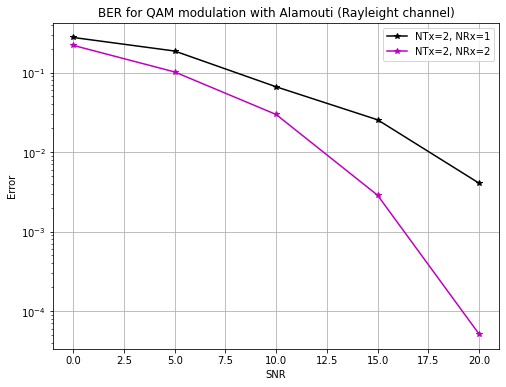

In [8]:
SNR = np.array(sim.results.params['SNR'])
ber = sim.results.get_result_values_list('ber')
ser = sim.results.get_result_values_list('ser')

fig, ax = plt.subplots(figsize=(8,6))
ax.semilogy(SNR, ber, '-k*', label='NTx=2, NRx=1')

ber2 = sim2.results.get_result_values_list('ber')
ser2 = sim2.results.get_result_values_list('ser')
ax.semilogy(SNR, ber2, '-m*', label='NTx=2, NRx=2')

ax.set_xlabel('SNR')
ax.set_ylabel('Error')
ax.set_title('BER for QAM modulation with Alamouti (Rayleight channel)'.format(sim.modulator.name))
ax.legend()

#grid(True, which='both', axis='both')
ax.grid()
# fig.show()

----------------------------

## Simulation of Alamouti with BPSK

Now lets repeat the simulation, but for BPSK modulation.
We can use the same SimulationRunner objects and only change the modulator, but we also need to call the "clear" method in both objects toerase results from the previous simulation.

In [9]:
sim.modulator = BPSK()
sim2.modulator = BPSK()

sim.clear()   # Erase results from the previous simulation with 16-QAM
sim2.clear()  # Erase results from the previous simulation with 16-QAM

Now we can run the simulations.

First we run the simulations for **NRx=1** with **BPSK** modulation

In [10]:
sim.simulate()
clear_output()
print("Elapsed Time for simulation 1: {0}".format(sim.elapsed_time))

Elapsed Time for simulation 1: 39.54s


and then we run the simulations for **NRx=2** with **BPSK** modulation.

In [11]:
sim2.simulate()
clear_output()
print("Elapsed Time for simulation 2: {0}".format(sim2.elapsed_time))

Elapsed Time for simulation 2: 46.78s


### Plot the Results

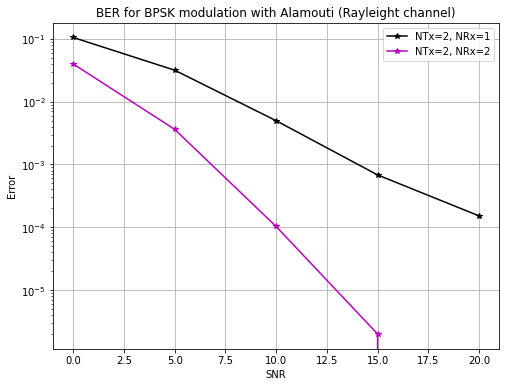

In [12]:
SNR = np.array(sim.results.params['SNR'])
ber = sim.results.get_result_values_list('ber')
ser = sim.results.get_result_values_list('ser')
len(SNR)

fig2, ax2 = plt.subplots(figsize=(8,6))
ax2.semilogy(SNR, ber, '-k*', label='NTx=2, NRx=1')

ber2 = sim2.results.get_result_values_list('ber')
ser2 = sim2.results.get_result_values_list('ser')
ax2.semilogy(SNR, ber2, '-m*', label='NTx=2, NRx=2')

ax2.set_xlabel('SNR')
ax2.set_ylabel('Error')
ax2.set_title('BER for BPSK modulation with Alamouti (Rayleight channel)'.format(sim.modulator.name))
ax2.legend()

#grid(True, which='both', axis='both')
ax2.grid()
# fig.show()